## Final Project Submission

Please fill out:
* Student name: Lameck Odallo
* Student pace: part time 
* Scheduled project review date/time: 27th July 1200
* Instructor name: Christine
* Blog post URL:


In [1]:
# Importing all the relevant packages (Including statistical ones)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="Set1")
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
%matplotlib inline

In [2]:
#importing the dataset 
df = pd.read_csv('data/Aviation_Data.csv', low_memory=False)

First Step was to explore the data to check the structure and completeness of data

Conclusion: The dataset contains over 90,000 records and more than 30 variables. Most of the data is in text format, with a few numeric columns. While some fields are mostly complete, others have significant missing data. There’s enough clean and relevant information to support meaningful analysis — particularly the injury counts, aircraft damage classification, and severity of events. Some data points may need to be dropped, but with 90+K observations this may not be a huge risk. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

To determine the airplanes with the lowest risk, I started by prioritizing the identification variables for the airplanes, which without we can't really make any logical conclusions. The two variables are 'make'and 'model'

In [4]:
#exploring the plane identification variables - make
df['Make'].value_counts(dropna=False)


Cessna                    22227
Piper                     12029
CESSNA                     4922
Beech                      4330
PIPER                      2841
                          ...  
RICHARD S DUNCAN              1
Steinorth                     1
Lucky                         1
GLOS WALLIS RICHARD JR        1
Cable-breigler                1
Name: Make, Length: 8238, dtype: int64

In [5]:
#exploring the plane identification variables - model
df['Model'].value_counts(dropna=False)

152               2367
172               1756
NaN               1551
172N              1164
PA-28-140          932
                  ... 
F206C                1
DC 9 82(MD-82)       1
COMP-AIR-6           1
415 CD               1
KitFox IV            1
Name: Model, Length: 12319, dtype: int64

The model variable does not seem as useful for now, but let's see if we can use it for any imputation later

In [6]:
#clean up of the 'make'variable
## since there is a mix of upper and lower case for the values contained in the 'make variable'
### first step is to sentence-case the 'make'variable as i'll be using it in visualizations (normalizing)
df['Make'] = df['Make'].str.strip().str.title()

In [7]:
df['Make'].value_counts(dropna=False)

Cessna                27149
Piper                 14870
Beech                  5372
Boeing                 2745
Bell                   2722
                      ...  
Eastern Ultralight        1
Daniel J. Lee             1
Aerofab                   1
Berrie                    1
Wootton, John             1
Name: Make, Length: 7588, dtype: int64

In [8]:
#Note that the code below creates a long t
#makes_list = sorted(df['Make'].dropna().unique().tolist())
#for make in makes_list:
 #   print(make)

From the above code (now muted, as it creates a long list), I realized that see that there are string values that were very closely related such as Aero Tek Inc.
Aero Tek, Inc.
Aero Vodochody
Aero Vodochody Aero Works
Aero Vodochody Aero. Works
which prompted me to consider fuzzy matching but in a new variable, so that the original variable remains unchanged

In [9]:
#let us first see what the top 50 makes are - this is arbitrary but it gives us a good indicator of the most used flights and what the company would consider
top_makes = df['Make'].value_counts().head(50)
top_makes.to_frame(name="Frequency")

,Frequency
Cessna,27149
Piper,14870
Beech,5372
Boeing,2745
Bell,2722
Mooney,1334
Robinson,1230
Grumman,1172
Bellanca,1045
Hughes,932


In [10]:
pip install 'thefuzz[speedup]'

Note: you may need to restart the kernel to use updated packages.


In [11]:
#implementing the fuzzy match process

from thefuzz import process

# Step 1: Convert the top_makes DataFrame to a list 
top_50_list = top_makes.index.tolist()  

# Step 2: Define the fuzzy match function
def match_to_top_50(make):
    if pd.isna(make):
        return None  
    match, score = process.extractOne(make, top_50_list)
    if score >= 85:
        return match  
    else:
        return None   

# Step 3: Apply the match function 
df['Matched_Make'] = df['Make'].apply(match_to_top_50)

df[['Make', 'Matched_Make']].sample(10)  


,Make,Matched_Make
44732,Air Tractor,Air Tractor
70745,Cessna,Cessna
70259,Cessna,Cessna
3796,Cessna,Cessna
50041,Robert D. Wood,None
53423,Cessna,Cessna
21041,Van,None
30131,Boeing,Boeing
1194,Piper,Piper
60313,Beech,Beech


In [12]:
#exporting the data set to see how the fuzzy match worked
df[['Make', 'Matched_Make']].to_csv("all_make_matches.csv", index=False)

In [13]:
#this is a variable of interest, we can use it a control variable 
df['Amateur.Built'].unique()

array(['No', 'Yes', nan], dtype=object)

In [14]:
#df['Number.of.Engines'].describe()  
df['Purpose.of.flight'].value_counts()

Personal                     49448
Instructional                10601
Unknown                       6802
Aerial Application            4712
Business                      4018
Positioning                   1646
Other Work Use                1264
Ferry                          812
Aerial Observation             794
Public Aircraft                720
Executive/corporate            553
Flight Test                    405
Skydiving                      182
External Load                  123
Public Aircraft - Federal      105
Banner Tow                     101
Air Race show                   99
Public Aircraft - Local         74
Public Aircraft - State         64
Air Race/show                   59
Glider Tow                      53
Firefighting                    40
Air Drop                        11
ASHO                             6
PUBS                             4
PUBL                             1
Name: Purpose.of.flight, dtype: int64

In [15]:
#df['Air.carrier'].unique()

The variables below are our key quantitative variables

In [16]:
#these are key risk variables to see if 
df[['Total.Fatal.Injuries','Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']].describe()

,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,77488.000000,76379.000000,76956.000000,82977.000000
mean,0.647855,0.279881,0.357061,5.325440
std,5.485960,1.544084,2.235625,27.913634
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,2.000000
max,349.000000,161.000000,380.000000,699.000000


Analysis 1: To begin assessing aircraft risk, I first investigated whether flight safety has improved over time. This helps determine whether incidents are becoming less deadly — a foundational question before comparing risk across aircraft makes.

In [17]:
injury_cols = [
    'Total.Fatal.Injuries',
    'Total.Serious.Injuries',
    'Total.Minor.Injuries'
]

In [18]:
#I made the decision to drop missing values instead of replacing them with 0 as 0 and missing, in a dataset with acual zeros means different things
df_clean = df.dropna(subset=injury_cols + ['Event.Date']).copy()

In [19]:
# Convert Event.Date to datetime, and extract the year
df_clean['Event.Date'] = pd.to_datetime(df_clean['Event.Date'], errors='coerce')
df_clean['Year'] = df_clean['Event.Date'].dt.year

In [20]:
yearly_totals = df_clean.groupby('Year')[injury_cols].sum().reset_index()

In [21]:
melted_totals = yearly_totals.melt(id_vars='Year', 
                                   var_name='Injury Type', 
                                   value_name='Total Count')

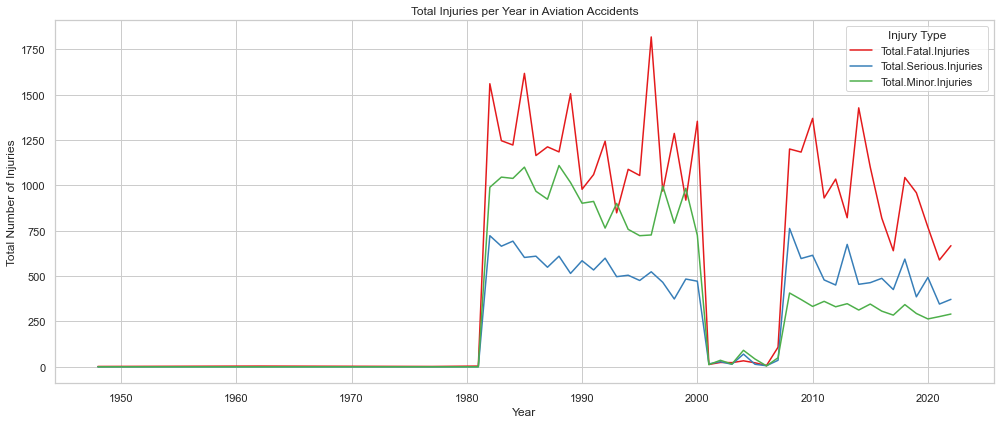

In [22]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=melted_totals, x='Year', y='Total Count', hue='Injury Type')
plt.title("Total Injuries per Year in Aviation Accidents")
plt.xlabel("Year")
plt.ylabel("Total Number of Injuries")
plt.grid(True)
plt.tight_layout()
plt.show()

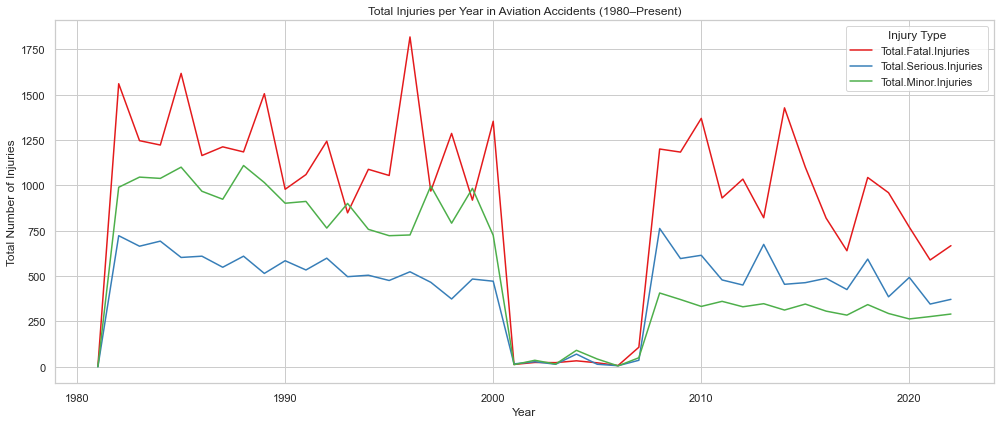

In [23]:
#excluding the data up until 1980, seeing that there is not much variability in the data before the year 1980
filtered_data = melted_totals[melted_totals['Year'] >= 1980]
# Plot the filtered data
plt.figure(figsize=(14, 6))
sns.lineplot(data=filtered_data, x='Year', y='Total Count', hue='Injury Type')
plt.title("Total Injuries per Year in Aviation Accidents (1980–Present)")
plt.xlabel("Year")
plt.ylabel("Total Number of Injuries")
plt.grid(True)
plt.tight_layout()
plt.show()

The next analysis was to generate a risk index, I decided to use PCA for the risk index (combining the injuries) that I could use as my dependent variable for any subsequent analyses

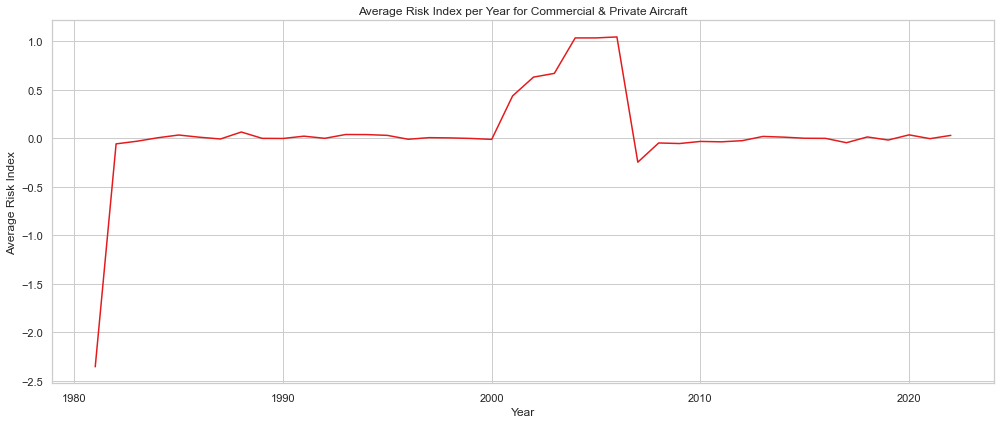

In [24]:
#creating a risk index 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
injury_cols = [
    'Total.Fatal.Injuries',
    'Total.Serious.Injuries',
    'Total.Minor.Injuries'
]

target_purposes = ['Personal', 'Business', 'Executive/corporate', 'Air Carrier', 'Commuter']


# Filter rows that have target purposes and complete injury data
df_target = df_clean[
    df_clean['Purpose.of.flight'].isin(target_purposes) &
    df_clean[injury_cols].notna().all(axis=1)
].copy()

# Standardize the injury columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_target[injury_cols])

# Perform PCA
pca = PCA(n_components=1)
df_target['Risk_Index'] = pca.fit_transform(X_scaled)

# Extract year from already-prepared column
df_target = df_target[df_target['Year'] >= 1980]
# Average risk per year
risk_by_year = df_target.groupby('Year')['Risk_Index'].mean().reset_index()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(data=risk_by_year, x='Year', y='Risk_Index')
plt.title("Average Risk Index per Year for Commercial & Private Aircraft")
plt.xlabel("Year")
plt.ylabel("Average Risk Index")
plt.grid(True)
plt.tight_layout()
plt.show()

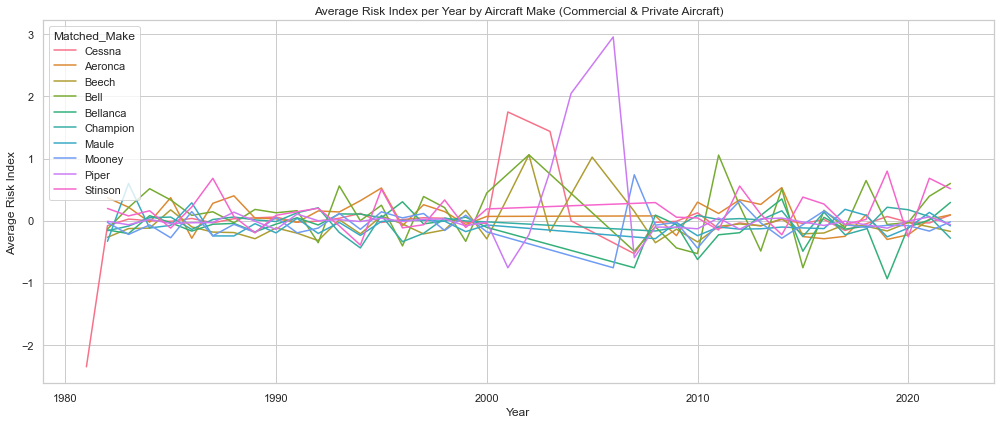

In [26]:
# Identify top 10 most common aircraft makes
top_makes = df_target['Matched_Make'].value_counts().head(10).index.tolist()

# Filter to include only those top makes
df_top_makes = df_target[df_target['Matched_Make'].isin(top_makes)].copy()

# roup by Year and Make to calculate average risk index
risk_by_year_make = df_top_makes.groupby(['Year', 'Matched_Make'])['Risk_Index'].mean().reset_index()

# Step: Plot using seaborn
plt.figure(figsize=(14, 6))
sns.lineplot(data=risk_by_year_make, x='Year', y='Risk_Index', hue='Matched_Make')
plt.title("Average Risk Index per Year by Aircraft Make (Commercial & Private Aircraft)")
plt.xlabel("Year")
plt.ylabel("Average Risk Index")
plt.grid(True)
plt.tight_layout()
plt.show()


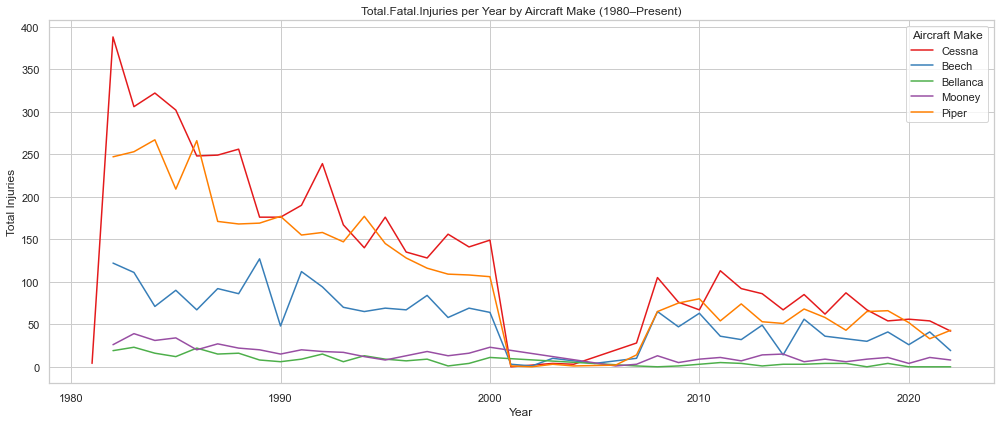

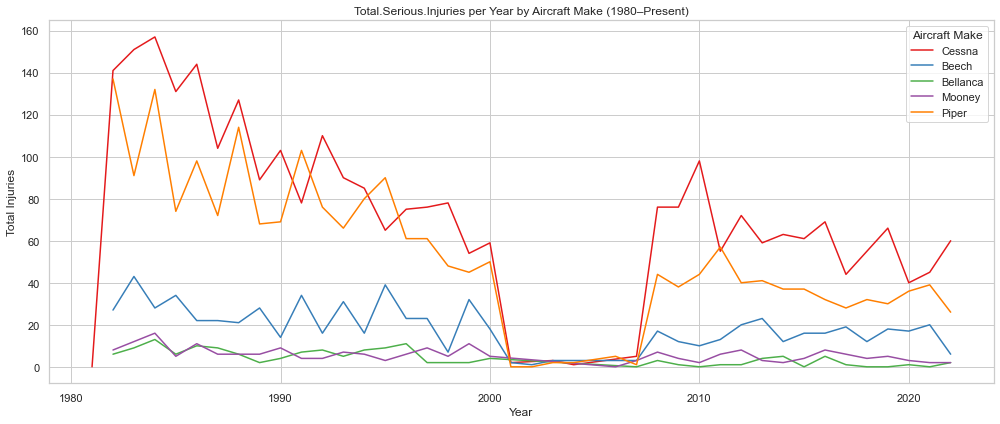

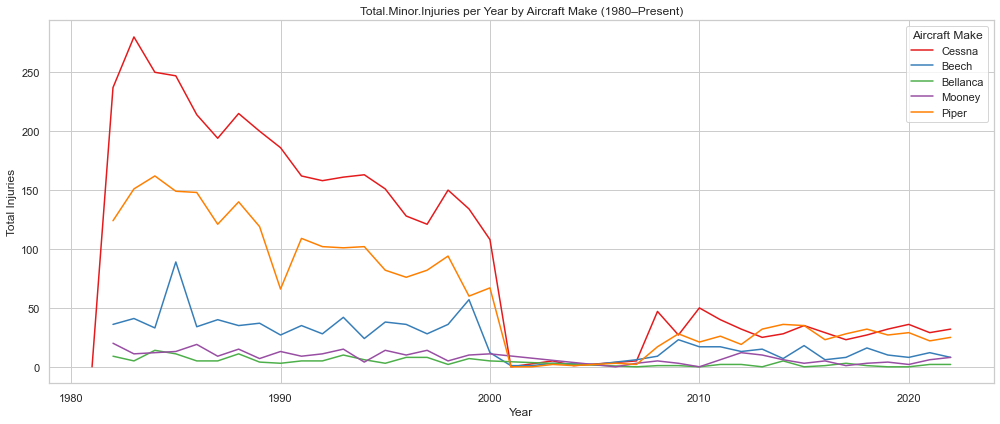

In [31]:
# Injury columns to focus on
injury_cols = ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries']

# Filter to relevant purposes and clean years
target_purposes = ['Personal', 'Business', 'Executive/corporate', 'Air Carrier', 'Commuter']
df_filtered = df_clean[
    df_clean['Purpose.of.flight'].isin(target_purposes) &
    df_clean['Year'].notna() &
    df_clean['Matched_Make'].notna() &
    (df_clean['Year'] >= 1980)
]

# Melt injury columns into long format
melted_by_make = df_filtered.melt(
    id_vars=['Year', 'Matched_Make'],
    value_vars=injury_cols,
    var_name='Injury Type',
    value_name='Count'
)

# Drop missing injury counts
melted_by_make = melted_by_make[melted_by_make['Count'].notna()]

# Identify top 5 most frequent cleaned makes
top_5_matched = df_filtered['Matched_Make'].value_counts().head(5).index.tolist()

# Filter to top 5
melted_by_make = melted_by_make[melted_by_make['Matched_Make'].isin(top_5_matched)]

# Aggregate total injuries
totals_by_make = (
    melted_by_make
    .groupby(['Year', 'Matched_Make', 'Injury Type'])['Count']
    .sum()
    .reset_index(name='Total Count')
)
# List of injury types
injury_types = ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries']

# Loop and plot each injury type separately
for injury in injury_types:
    plt.figure(figsize=(14, 6))
    sns.lineplot(
        data=totals_by_make[totals_by_make['Injury Type'] == injury],
        x='Year',
        y='Total Count',
        hue='Matched_Make'
    )
    plt.title(f"{injury} per Year by Aircraft Make (1980–Present)")
    plt.xlabel("Year")
    plt.ylabel("Total Injuries")
    plt.grid(True)
    plt.legend(title="Aircraft Make")
    plt.tight_layout()
    plt.show()